In [63]:
# Packages
import pandas as pd
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import shutil
import re

In [ ]:
import os, re, pickle
import numpy as np
import pandas as pd

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
chem_res = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/bulk_potentials_swing.csv"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

df = pd.read_csv(chem_res)
pressures = df["pressure_bar"].unique().tolist()

CHEM_COL = "chem_potential_bulk"

for pressure in pressures:
    for temp_folder in os.listdir(base_dir):
        temp_path = os.path.join(base_dir, temp_folder)
        if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
            continue

        for filename in os.listdir(temp_path):
            if not filename.endswith(".pkl"):
                continue

            m = pattern.match(filename)
            if not m:
                continue

            struct_name, temp = m.groups()
            temp_k = float(temp)
            file_path = os.path.join(temp_path, filename)

            # Pickle-Daten laden
            with open(file_path, "rb") as f:
                data = pickle.load(f)

            arr = np.asarray(data, dtype=np.float64).squeeze()
            arr = arr[np.isfinite(arr)]  # NaN/Inf entfernnen

            # Chemisches Potential addieren, falls vorhanden
            sub = df[(df["pressure_bar"] == pressure) &
                     (df["temperature_kelvin"] == temp_k)]

            if not sub.empty:
                chem_val = float(sub[CHEM_COL].mean())
                arr = arr + chem_val

            # Min/Max dieser Struktur
            if arr.size > 0:
                local_min = arr.min()
                local_max = arr.max()

                # global updaten
                global_min = min(global_min, local_min)
                global_max = max(global_max, local_max)

print("==================================")
print(" GLOBALER MIN-WERT aller Pickles:", global_min)
print(" GLOBALER MAX-WERT aller Pickles:", global_max)
print("==================================")


In [ ]:
VEXT_MAX = 10.1
VEXT_MIN = -15.1
N_BINS   = 25

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
chem_res = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/bulk_potentials_swing.csv"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

df = pd.read_csv(chem_res)
pressures = df["pressure_bar"].unique().tolist()

print(pressures)
# Falls deine Spalte anders heißt, hier anpassen:
CHEM_COL = "chem_potential_bulk"
if CHEM_COL not in df.columns:
    raise KeyError(f"Spalte '{CHEM_COL}' fehlt in {chem_res}. Vorhanden: {list(df.columns)}")
    
all_dfs = []
counter = 0

for pressure in pressures:
    for temp_folder in os.listdir(base_dir):
        temp_path = os.path.join(base_dir, temp_folder)
        if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
            continue
    
        print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
        rows = []
    
        # alle pickle daten
        for filename in os.listdir(temp_path):
            if not filename.endswith(".pkl"):
                continue
            
            m = pattern.match(filename)
            if not m:
                print(f"Übersprungen (kein gültiger Name): {filename}")
                continue
    
            struct_name, temp = m.groups()
            temp_k = float(temp)
            #print(f"Aktuelle temp: {temp_k}")
            file_path = os.path.join(temp_path, filename)
    
            # Entpickeln
            with open(file_path, "rb") as f:
                data = pickle.load(f)
    
            arr = np.asarray(data, dtype=np.float64).squeeze()
            arr = arr[np.isfinite(arr)]  # NaN/Inf entfernen
            #print(f"arr_pickel{arr}")
            if arr.size != 64**3:
                counter += 1
    
            # ---------- NEU: chem_res nach Druck & Temperatur filtern und addieren ----------
            sub = df[(df["pressure_bar"] == pressure) & (df["temperature_kelvin"] == temp_k)]
            if not sub.empty:
                chem_val = float(sub[CHEM_COL].mean())   # bei mehreren Treffern: Mittelwert
                arr = arr + chem_val
                #print(f"arr_chem{arr}")
            # -------------------------------------------------------------------------------
    
            if arr.size == 0:
                hist = np.zeros(N_BINS, dtype=int)
                edges = np.linspace(0, 1, N_BINS + 1)
            else:
                #arr = np.clip(arr, VEXT_MIN, VEXT_MAX)
                hist, edges = np.histogram(arr, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
    
            # struktur
            entry = {"structure_name": struct_name, "temperature_kelvin": temp_k, "pressure_bar": pressure}
            entry.update({f"bin_{i}": int(v) for i, v in enumerate(hist)})
            entry["x_max"] = float(edges[-1])
            entry["x_min"] = float(edges[0])
            rows.append(entry)
    
        if rows:
            df_temp = pd.DataFrame(rows)
            all_dfs.append(df_temp)
            print(f"{len(rows)} Strukturen verarbeitet")

# df_all zusammenführen
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
#print(f"\n Gesamt-DataFrame mit {len(df_all)} Zeilen erstellt")

# csv
out_name = f"Vext_allTEMP_pressure_{N_BINS}b_rangeinc_swing.csv"
out_path = os.path.join('/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/', out_name)
df_all.to_csv(out_path, index=False)

print(f"Datei gespeichert unter:\n{out_path}")

In [78]:
VEXT_MAX = 10.1
VEXT_MIN = -15
N_BINS   = 95

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")  # Strukturkürzel + Temperatur

# -------- Sammeln --------
all_dfs = []
counter_badshape = 0

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)
    # nur Ordner, die mit "Vext_" beginnen (z. B. Vext_300K etc.)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        temp_k = float(temp)
        file_path = os.path.join(temp_path, filename)

        # Entpacken
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # In 1D-Array wandeln und auf gültige Zahlen beschränken
        arr = np.asarray(data, dtype=np.float64).squeeze()
        arr = arr[np.isfinite(arr)]

        if arr.size != 64**3:
            counter_badshape += 1  # nur Info/Debug

        # Histogramm bilden (ohne chemisches Potential, ohne Druck)
        # Falls du die Achsen fix halten willst, range=(VEXT_MIN, VEXT_MAX) aktivieren.
        # hist, edges = np.histogram(arr, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
        hist, edges = np.histogram(arr, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))

        entry = {
            "structure_name": struct_name,
            "temperature_kelvin": temp_k,
            # KEIN pressure_bar mehr
            **{f"bin_{i}": int(v) for i, v in enumerate(hist)},
            "x_min": float(edges[0]),
            "x_max": float(edges[-1]),
        }
        rows.append(entry)

    if rows:
        df_temp = pd.DataFrame(rows)
        all_dfs.append(df_temp)
        print(f"{len(rows)} Strukturen verarbeitet")

# -------- Zusammenführen + Speichern --------
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
print(f"\nGesamt-DataFrame mit {len(df_all)} Zeilen erstellt")
print(f"Anzahl Dateien mit unerwarteter Größe: {counter_badshape}")

out_name = "Vext_allTEMP_hist_no_pressure_no_chem_95b_swing.csv"
out_path = os.path.join('/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/', out_name)
df_all.to_csv(out_path, index=False)
print(f"Datei gespeichert unter:\n{out_path}")


Bearbeite Temperatur-Ordner: Vext_400
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_348
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_300
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_298
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_373
245 Strukturen verarbeitet

Gesamt-DataFrame mit 1225 Zeilen erstellt
Anzahl Dateien mit unerwarteter Größe: 0
Datei gespeichert unter:
/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_95b_swing.csv


Vext HIST: Daten Enpickeln und Histogrammieren

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Einstellungen ---
csv_files = [
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_exp_rangelogBin_10.1_-15_100Bins.csv",
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_noexp_rangelinBin_10.1_-15_100Bins.csv",
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_noexp_rangelogBin_10.1_-15_100Bins.csv",
    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP/Vext_allTEMP_exp_rangelogBin_10.1_-15_100Bins_test.csv",
]

structure = "MWW"
temperature = 500   # gewünschte Temperatur in K
pressure = None     # z. B. 1.0, falls vorhanden

# --- Schleife über alle CSVs ---
for file in csv_files:
    if not os.path.exists(file):
        print(f"⚠️ Datei nicht gefunden: {file}")
        continue

    df = pd.read_csv(file)

    # Spaltennamen automatisch erkennen
    structure_col = "structure_name" if "structure_name" in df.columns else "structure"
    temp_col = "temperature_kelvin" if "temperature_kelvin" in df.columns else "temperature"

    # Filter nach Struktur, Temperatur und ggf. Druck
    if pressure is not None and "Pressure_bar" in df.columns:
        df_sel = df[
            (df[structure_col] == structure) &
            (df[temp_col] == temperature) &
            (np.isclose(df["Pressure_bar"], pressure, atol=1e-3))
        ]
    else:
        df_sel = df[
            (df[structure_col] == structure) &
            (df[temp_col] == temperature)
        ]

    if df_sel.empty:
        print(f"⚠️ Keine Daten für Struktur {structure} in {os.path.basename(file)} gefunden.")
        continue

    # Falls mehrere Zeilen vorhanden sind, nimm die erste
    row = df_sel.iloc[0]

    # Histogrammdaten extrahieren
    bin_cols = [c for c in df.columns if c.startswith("bin_")]
    y = row[bin_cols].values
    x_min, x_max = row["x_min"], row["x_max"]

    # X-Achse rekonstruieren
    x_edges = np.linspace(x_min, x_max, len(bin_cols) + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(x_centers, y, marker="o", lw=1.5)
    plt.grid(True, alpha=0.4)

    plt.title(f"{structure} – {int(temperature)} K\n{os.path.basename(file)}")
    plt.yscale('log')
    plt.xlabel("Vext")
    plt.ylabel("Häufigkeit pro Bin")
    plt.tight_layout()
    plt.show()



In [ ]:
VEXT_MAX = 10.0
VEXT_MIN = -15.0
N_BINS   = 500

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

# --- Alle Vext-Werte sammeln ---
all_values = []
counter = 0

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"Bearbeite Temperatur-Ordner: {temp_folder}")

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (ungültiger Name): {filename}")
            continue

        file_path = os.path.join(temp_path, filename)

        with open(file_path, "rb") as f:
            data = pickle.load(f)

        arr = np.asarray(data, dtype=np.float64).squeeze()
        arr = arr[np.isfinite(arr)]

        if arr.size != 64**3:
            counter += 1
            print(f"{filename} hat unerwartete Größe {arr.size}")
            continue

        # Werte clippen (damit Extremwerte das Histogramm nicht verzerren)
        arr = np.clip(arr, VEXT_MIN, VEXT_MAX)
        all_values.append(arr)

# --- Alle Werte zu einem Array verbinden ---
if len(all_values) == 0:
    raise ValueError("Keine Daten gefunden!")

all_values = np.concatenate(all_values)
print(f" Gesamtzahl Werte: {len(all_values):,}")

# --- Histogramm ---
hist, edges = np.histogram(all_values, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))

#print("Fertig! Histogramm über alle Strukturen geplottet.")

In [ ]:
# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(0.5*(edges[1:]+edges[:-1]), hist, lw=1.5)
plt.title(f"Histogramm aller Strukturen ({len(all_values):,} Werte)")
plt.xlabel("Vext")
plt.ylabel("Anzahl")
plt.ylim(0, 1500000)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

HIST TEST - NO CSV

In [55]:
# Packages

import pandas as pd
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import shutil
import re
from scipy.spatial import distance

N_BINS=100
VEXT_MIN=-15
VEXT_MAX=10

file_path1 = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/Vext_298/Vext_SBN_298.pkl"
file_path2 = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/Vext_298/Vext_MWW_298.pkl"

with open(file_path1, "rb") as f:
    data = pickle.load(f)

with open(file_path2, "rb") as f:
    doto = pickle.load(f)


In [56]:
"""
arr1 = np.asarray(np.exp(-data), dtype=np.float64).squeeze()
arr1 = arr1[np.isfinite(arr1)]
arr2 = np.asarray(np.exp(-doto), dtype=np.float64).squeeze()
arr2 = arr2[np.isfinite(arr2)]  # NaN/Inf entfernen

""" #betaVext und -betaVext
arr1 = np.asarray(data, dtype=np.float64).squeeze()
arr1 = arr1[np.isfinite(arr1)]
arr2 = np.asarray(doto, dtype=np.float64).squeeze()
arr2 = arr2[np.isfinite(arr2)]  # NaN/Inf entfernen

arr1 = np.clip(arr1, VEXT_MIN, VEXT_MAX)
arr2 = np.clip(arr2, VEXT_MIN, VEXT_MAX)


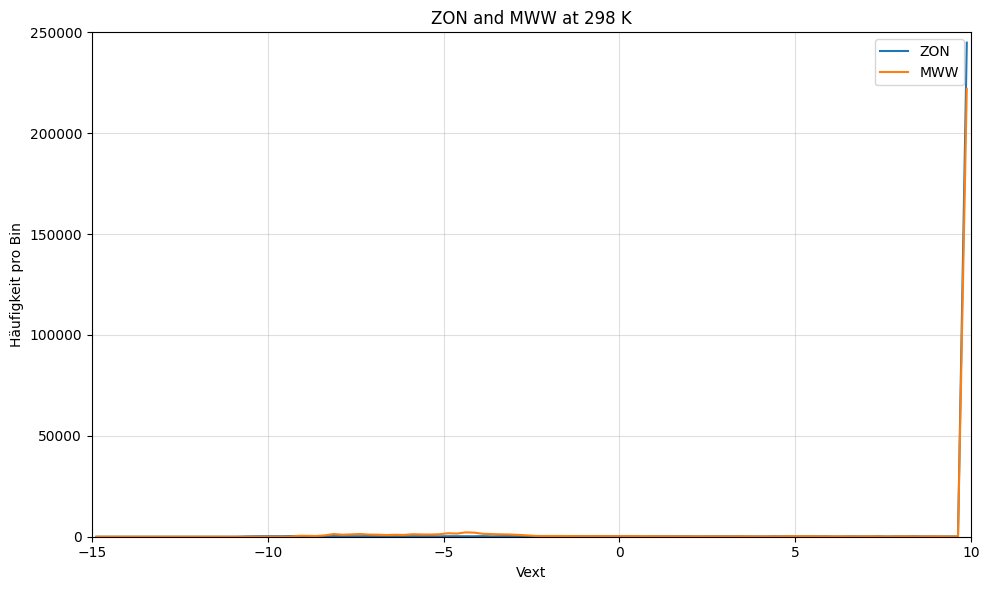

In [57]:
""" 
hist1, edges1 = np.histogram(np.exp(arr1), bins=np.logspace(0, (10), N_BINS))#, range=(VEXT_MIN, VEXT_MAX))
hist2, edges1 = np.histogram(np.exp(arr2), bins=np.logspace(0, (10), N_BINS))#, range=(VEXT_MIN, VEXT_MAX))

hist11, edges11 = np.histogram(np.exp(-arr1), bins=np.logspace(0, (10), N_BINS))#, range=(VEXT_MIN, VEXT_MAX))
hist22, edges22 = np.histogram(np.exp(-arr2), bins=np.logspace(0, (10), N_BINS))#, range=(VEXT_MIN, VEXT_MAX))


hist1, edges1 = np.histogram(np.exp(arr1), bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
hist2, edges1 = np.histogram(np.exp(arr2), bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
hist11, edges11 = np.histogram(np.exp(-arr1), bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
hist22, edges22 = np.histogram(np.exp(-arr2), bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
"""
hist1, edges1 = np.histogram(arr1, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
hist2, edges2 = np.histogram(arr2, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))

x_edges1 = 0.5 * (edges1[:-1] + edges1[1:])
x_edges2 = 0.5 * (edges11[:-1] + edges11[1:])  # für die negierten

# --- Plots ---
plt.figure(figsize=(10, 6))

# Original-Histogramme
plt.plot(x_edges1, hist1, label="ZON", lw=1.5)
plt.plot(x_edges1, hist2, label="MWW", lw=1.5)


# --- Darstellung ---
plt.title("ZON and MWW at 298 K")
plt.xlabel("Vext")
plt.ylabel("Häufigkeit pro Bin")
plt.xlim(-15, 10)
plt.ylim(0, 250000)
plt.grid(True, alpha=0.4)
plt.yscale('linear')
plt.xscale('linear')
plt.legend()
plt.tight_layout()
plt.show()

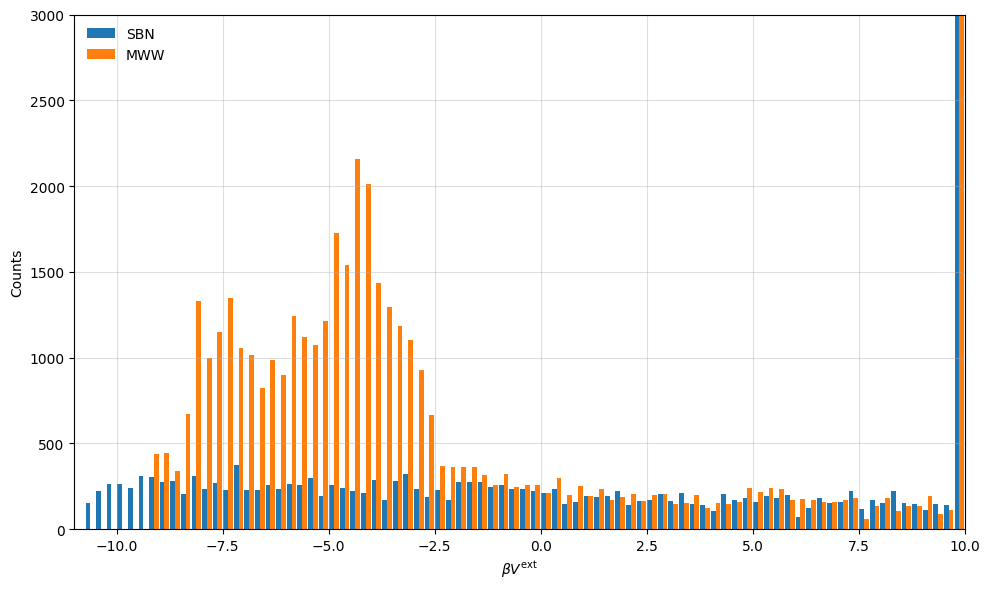

In [64]:
hist1, edges1 = np.histogram(arr1, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))
hist2, edges2 = np.histogram(arr2, bins=N_BINS, range=(VEXT_MIN, VEXT_MAX))

# Bin-Mitten
x_centers = 0.5 * (edges1[:-1] + edges1[1:])

# Balkenbreite als Anteil der Binbreite
bin_width = (edges1[1] - edges1[0])
width = bin_width * 0.45       # zwei Balken nebeneinander, etwas Abstand dazwischen

# --- Plot ---
plt.figure(figsize=(10, 6))

# Balkendiagramm (nebeneinander)
plt.bar(x_centers - width/2, hist1, width=width, label="SBN")
plt.bar(x_centers + width/2, hist2, width=width, label="MWW")

# --- Darstellung ---
#plt.title("External Potential Histogram at 298 K")
plt.xlabel(r"$\beta V^{\mathrm{ext}}$")
plt.ylabel("Counts")
plt.xlim(-11, VEXT_MAX)
plt.ylim(0, max(hist1.max(), hist2.max()) * 1.1)
plt.ylim(0, 3000)
plt.grid(True, alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("Iso2.png", dpi=400, bbox_inches="tight")
plt.show()